# MNIST classification

- https://en.wikipedia.org/wiki/MNIST_database

1. Naive-Bayes Classifier
    - skip. Less interesting.
2. Neural Netowrk
    - mini-batch

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sklearn

print('numpy: ', np.__version__)
print('sklearn: ', sklearn.__version__)

## Dataset can be obtained directly from `torchvision`

In [78]:
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True)

### Returned are PIL Image and target label

<PIL.Image.Image image mode=L size=28x28 at 0x15A9B33C488> 5


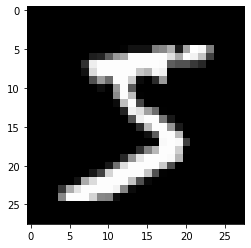

In [81]:
im, label = mnist_train[0]
plt.imshow(im, cmap='gray')
print(im, label)

### Convert to Tensor and A Custom torchvision.transformation for Binarization

In [82]:
class MyBinarization:
    """ convert a gray scale tensor [0, 1] to binary tensor of {0., 1.}"""
    def __init__(self, threshold=0.5):
        self.threshold=threshold
        
    def __call__(self, im):
        bright = im > self.threshold
        im[bright] = 1.
        im[~bright] = 0.
        return im

data_transform = torchvision.transforms.Compose([#transforms.Grayscale(), 
                                     torchvision.transforms.ToTensor(),
                                     torchvision.transforms.Lambda(lambda im: (im>0.5).float()), # another way to do binarizaiton
                                     #MyBinarization() ,
                                     torchvision.transforms.Lambda(lambda im: im.reshape(-1)) # 
                                    ])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=data_transform)
mnist_test  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=data_transform)

(torch.Size([784]), torch.float32, 5, array([0., 1.], dtype=float32), int, 784)

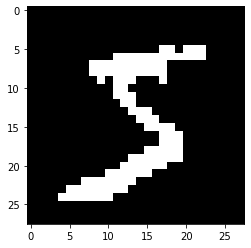

In [83]:
im, label = mnist_train[0]
plt.imshow(im.reshape(28,28), cmap='gray')
im.shape, im.dtype, label, np.unique(im), type(label), 28*28

## Bernoulli Naive Bayes
- https://github.com/dsgiitr/d2l-pytorch/blob/master/Ch04_The_Preliminaries_A_Crashcourse/Naive_Bayes_Classification.ipynb

In [84]:
xcount = torch.ones((im.reshape(-1).shape[0],10)).float()
ycount = torch.ones((10))

for im, label in mnist_train:
    xcount[:,label] += im.reshape(-1)
    ycount[label] += 1
#

In [85]:
py = ycount / ycount.sum()
px = xcount / ycount.unsqueeze(0) # each row is divided by ycount

- For example, px[300,:] shows the Bernoulli probability at the location 300 for the class labels.
- px[300,**k**] is the probability of being a bright pixel at the location 300 provided the class is **k**

In [86]:
px[300,:]

tensor([0.6437, 0.0114, 0.3167, 0.1797, 0.3377, 0.1046, 0.0781, 0.4349, 0.4508,
        0.3057])

Class Conditional Probabilities: 


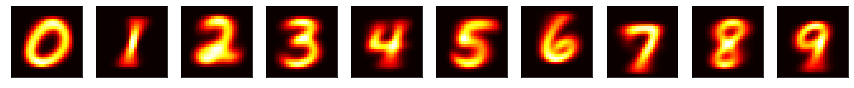

Class Prior Probabilities:
  tensor([0.0987, 0.1124, 0.0993, 0.1022, 0.0974, 0.0904, 0.0986, 0.1044, 0.0975,
        0.0992])


In [87]:
fig, axes = plt.subplots(1,10, figsize=(15,10))
print('Class Conditional Probabilities: ')
for i in range(10):
    axes[i].imshow(px[:,i].reshape(28,28).numpy(), cmap='hot')
    axes[i].axes.get_xaxis().set_visible(False)
    axes[i].axes.get_yaxis().set_visible(False)
plt.show()
print('Class Prior Probabilities:\n ', py)

* Notice that the images are well aligned within classes.

In [88]:
np.unique(mnist_train.targets, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
       dtype=int64))

## PyTorch Neural Network

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import torch
import torch.utils
import torch.nn as nn
import torch.optim
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device('cpu')
print (device)

cuda:0


## Data Preparation

In [8]:
data_transform = torchvision.transforms.Compose([#transforms.Grayscale(), 
                                     torchvision.transforms.ToTensor(),
                                     torchvision.transforms.Lambda(lambda im: im.reshape(-1))
                                    ])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=data_transform)
mnist_test  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=data_transform)

batch_size=4
data_loader_train = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

Text(0.5, 1.0, 'label: 5')

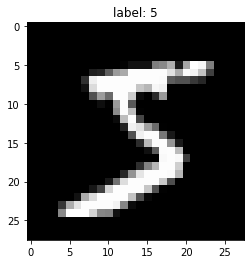

In [9]:
# Explore
im, label = mnist_train[0]
plt.imshow(im.reshape(28,28), cmap='gray')
plt.title(f'label: {label}')

torch.Size([4, 784])


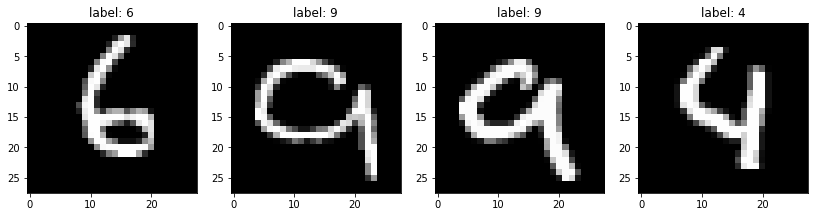

In [10]:
for batch_im, batch_label in data_loader_train:
    print(batch_im.shape)
    fig, axes = plt.subplots(1,batch_im.shape[0], figsize=(14,8))
    for i in range(batch_im.shape[0]):
        axes[i].imshow(batch_im[i].reshape(28,28), cmap='gray')
        axes[i].set_title(f'label: {batch_label[i]}')
    break

### Network Design

In [31]:
# Two hidden layer network

def myNetwork(in_features, n_targget):
    net = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=in_features//2),
        nn.Tanh(),
        nn.Linear(in_features=in_features//2, out_features=n_target),
        nn.LogSoftmax(dim=1)
        )
    return net
#

### Revise the action of `LogSoftMax()`

In [12]:
logsoftmax = nn.LogSoftmax(dim=1)
score_batch = torch.randn((4,10))
lsm = logsoftmax(score_batch) # log softmax along the dimension
print('Score Batch:\n', score_batch)
print('LogSoftMax:\n', lsm)
print('SoftMax:\n', torch.exp(lsm))
print('argmax(dim=1):\n', torch.argmax(lsm, dim=1))

Score Batch:
 tensor([[ 0.2204, -0.3269,  0.2302, -0.7457,  0.6498,  2.1011,  0.3348,  0.2972,
         -0.9492, -2.0973],
        [-0.4388,  0.5465,  1.1597,  1.9615, -0.2737, -1.5286,  0.2719,  0.9646,
          2.5155, -0.7758],
        [ 1.2172, -0.7651,  0.5614, -0.3824,  0.3000,  2.5931, -0.4821, -0.4242,
         -0.6840, -0.6602],
        [-0.6225,  0.7514, -1.2547,  0.0572, -0.8566, -0.8254, -0.4608,  0.3110,
          0.8874, -0.1711]])
LogSoftMax:
 tensor([[-2.6155, -3.1628, -2.6057, -3.5816, -2.1860, -0.7347, -2.5011, -2.5386,
         -3.7851, -4.9332],
        [-3.8538, -2.8685, -2.2554, -1.4535, -3.6887, -4.9436, -3.1431, -2.4504,
         -0.8995, -4.1909],
        [-1.9309, -3.9132, -2.5867, -3.5306, -2.8481, -0.5550, -3.6302, -3.5724,
         -3.8322, -3.8083],
        [-2.9380, -1.5642, -3.5702, -2.2583, -3.1722, -3.1409, -2.7764, -2.0046,
         -1.4281, -2.4866]])
SoftMax:
 tensor([[0.0731, 0.0423, 0.0739, 0.0278, 0.1124, 0.4796, 0.0820, 0.0790, 0.0227,
        

### Sanity Check with Dataset

In [33]:
in_features = 28*28
n_target = 10

net = myNetwork(in_features, n_target).to(device)
net, next(net.parameters()).is_cuda

(Sequential(
   (0): Linear(in_features=784, out_features=392, bias=True)
   (1): Tanh()
   (2): Linear(in_features=392, out_features=10, bias=True)
   (3): LogSoftmax()
 ), True)

In [34]:
# net working test
with torch.no_grad():
    for i in range(4):
        print(i, '------------------------------------')
        im_tensor, label = mnist_train[i]
        print(im_tensor.unsqueeze(0).shape)
        yp = net(im_tensor.unsqueeze(0).to(device)) # [Batch, data_features]
        pred = torch.argmax(yp, dim=1)
        print('log_P(y|x): ', yp)
        print('P(y|x): ', torch.exp(yp))
        print('argmax: ', pred.item())

0 ------------------------------------
torch.Size([1, 784])
log_P(y|x):  tensor([[-2.2869, -2.2507, -2.2092, -2.3654, -2.3545, -2.1557, -2.3689, -2.2819,
         -2.2108, -2.6128]], device='cuda:0')
P(y|x):  tensor([[0.1016, 0.1053, 0.1098, 0.0939, 0.0949, 0.1158, 0.0936, 0.1021, 0.1096,
         0.0733]], device='cuda:0')
argmax:  5
1 ------------------------------------
torch.Size([1, 784])
log_P(y|x):  tensor([[-2.2951, -2.0934, -2.3160, -2.3768, -2.2550, -2.1740, -2.5253, -2.3067,
         -2.3073, -2.4451]], device='cuda:0')
P(y|x):  tensor([[0.1008, 0.1233, 0.0987, 0.0928, 0.1049, 0.1137, 0.0800, 0.0996, 0.0995,
         0.0867]], device='cuda:0')
argmax:  1
2 ------------------------------------
torch.Size([1, 784])
log_P(y|x):  tensor([[-2.3163, -2.0918, -2.4537, -2.4307, -2.1866, -2.3441, -2.4155, -2.2432,
         -2.2167, -2.3933]], device='cuda:0')
P(y|x):  tensor([[0.0986, 0.1235, 0.0860, 0.0880, 0.1123, 0.0959, 0.0893, 0.1061, 0.1090,
         0.0913]], device='cuda:0')


### Sanity Check with data_loader

In [35]:
with torch.no_grad():
    for im_batch, label_batch in data_loader_train:
        im_batch, label_batch = im_batch.to(device), label_batch.to(device)
        print(im_batch.shape, im_batch.dtype, label_batch.shape)
        yp = net(im_batch) # [Batch, data_features]
        pred = torch.argmax(yp, dim=1)
        print('log_P(y|x):\n', yp)
        print ('P(y|x): ', torch.exp(yp))
        print('argmax: ', pred)
        break

torch.Size([128, 784]) torch.float32 torch.Size([128])
log_P(y|x):
 tensor([[-2.4495, -2.0737, -2.3388,  ..., -2.2090, -2.2958, -2.4333],
        [-2.4172, -2.4299, -2.2305,  ..., -2.2424, -2.1864, -2.5348],
        [-2.3795, -2.1104, -2.1352,  ..., -2.2865, -2.4778, -2.4789],
        ...,
        [-2.3828, -2.0548, -2.3524,  ..., -2.1935, -2.2937, -2.4925],
        [-2.3203, -2.2348, -2.1558,  ..., -2.2878, -2.2210, -2.4136],
        [-2.3782, -2.1401, -2.3659,  ..., -2.1635, -2.3060, -2.5171]],
       device='cuda:0')
P(y|x):  tensor([[0.0863, 0.1257, 0.0964,  ..., 0.1098, 0.1007, 0.0877],
        [0.0892, 0.0880, 0.1075,  ..., 0.1062, 0.1123, 0.0793],
        [0.0926, 0.1212, 0.1182,  ..., 0.1016, 0.0839, 0.0838],
        ...,
        [0.0923, 0.1281, 0.0951,  ..., 0.1115, 0.1009, 0.0827],
        [0.0982, 0.1070, 0.1158,  ..., 0.1015, 0.1085, 0.0895],
        [0.0927, 0.1176, 0.0939,  ..., 0.1149, 0.0997, 0.0807]],
       device='cuda:0')
argmax:  tensor([1, 8, 1, 8, 8, 1, 2, 2, 2,

### Training Loop

In [37]:
def performance(model, loss_fn, dataloader):
    model.eval()
    with torch.no_grad():
        loss, acc, n = 0., 0., 0.
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            ypred = model(x)
            loss += loss_fn(ypred, y).item() * len(y)
            p = torch.argmax(ypred, dim=1)
            acc += (p == y).sum().item()
            n += len(y)
        #
    loss /= n
    acc /= n
    return loss, acc
  
def training_loop(n_epochs, optim, model, loss_fn, dl_train, dl_val, hist=None):
    if hist is not None:
        pass
    else:
        hist = {'tloss': [], 'tacc': [], 'vloss': [], 'vacc': []}
        
    for epoch in range(1, n_epochs+1):
        tr_loss, tr_acc = 0., 0.
        n_data = 0
        for im_batch, label_batch in dl_train: # minibatch
            im_batch, label_batch = im_batch.to(device), label_batch.to(device)
            ypred = model(im_batch)
            loss_train = loss_fn(ypred, label_batch)
        
            optim.zero_grad()
            loss_train.backward()
            optim.step()

            
            # accumulate correct prediction
            tr_acc  += (torch.argmax(ypred.detach(), dim=1) == label_batch).sum().item() # number of correct predictions
            tr_loss += loss_train.item() * im_batch.shape[0]
            n_data  += im_batch.shape[0]
        #
        # statistics
        tr_loss /= n_data
        tr_acc  /= n_data
        #
        val_loss, val_acc = performance(model, loss_fn, dl_val)
        
        if epoch <= 5 or epoch % 1000 == 0 or epoch == n_epochs:
             print(f'Epoch {epoch}, tloss {tr_loss:.2f} t_acc: {tr_acc:.2f}  vloss {val_loss:.2f}  v_acc: {val_acc:.2f}')
            
        # record for history return
        hist['tloss'].append(tr_loss)
        hist['vloss'].append(val_loss) 
        hist['tacc'].append(tr_acc)
        hist['vacc'].append(val_acc)
        
    print ('finished training_loop().')
    return hist

In [39]:
batch_size=128
data_loader_train = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

### optimizer & loss_function

In [40]:
optimizer = torch.optim.SGD(net.parameters(), lr=1e-2)
loss_fn = nn.NLLLoss().to(device)

model = myNetwork(in_features, n_target)

In [41]:
history = training_loop(n_epochs=10,
                        optim=optimizer,
                        model=net,
                        loss_fn=loss_fn, 
                        dl_train=data_loader_train,
                        dl_val = data_loader_test
                        )

Epoch 1, tloss 1.43 t_acc: 0.71  vloss 0.84  v_acc: 0.83
Epoch 2, tloss 0.68 t_acc: 0.85  vloss 0.55  v_acc: 0.87
Epoch 3, tloss 0.51 t_acc: 0.87  vloss 0.45  v_acc: 0.89
Epoch 4, tloss 0.44 t_acc: 0.88  vloss 0.40  v_acc: 0.89
Epoch 5, tloss 0.41 t_acc: 0.89  vloss 0.37  v_acc: 0.90
Epoch 10, tloss 0.33 t_acc: 0.90  vloss 0.32  v_acc: 0.91
finished training_loop().


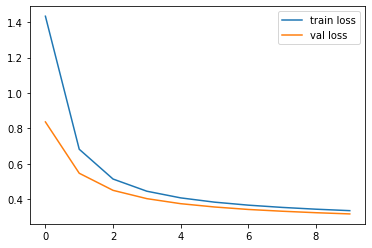

In [43]:
plt.plot(history['tloss'], label='train loss')
plt.plot(history['vloss'], label='val loss')
plt.legend()

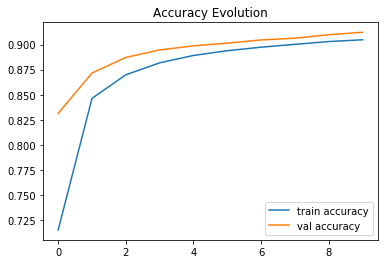

In [44]:
plt.title('Accuracy Evolution')
plt.plot(history['tacc'], label='train accuracy')
plt.plot(history['vacc'], label='val accuracy')
plt.legend()

### Do some more training

In [46]:
history = training_loop(n_epochs=50,
                        optim=optimizer,
                        model=net,
                        loss_fn=loss_fn, 
                        dl_train=data_loader_train,
                        dl_val = data_loader_test,
                        hist=history)

Epoch 1, tloss 0.33 t_acc: 0.91  vloss 0.31  v_acc: 0.91
Epoch 2, tloss 0.32 t_acc: 0.91  vloss 0.31  v_acc: 0.91
Epoch 3, tloss 0.32 t_acc: 0.91  vloss 0.30  v_acc: 0.92
Epoch 4, tloss 0.31 t_acc: 0.91  vloss 0.30  v_acc: 0.92
Epoch 5, tloss 0.31 t_acc: 0.91  vloss 0.29  v_acc: 0.92
Epoch 50, tloss 0.21 t_acc: 0.94  vloss 0.21  v_acc: 0.94
finished training_loop().


In [75]:
def plot_history(history):
    fig, axes = plt.subplots(1,2, figsize=(16,6))
    axes[0].set_title('Loss'); 
    axes[0].plot(history['tloss'], label='train'); axes[0].plot(history['vloss'], label='val')
    axes[0].legend()
    axes[1].set_title('Acc')
    axes[1].plot(history['tacc'], label='train'); axes[1].plot(history['vacc'], label='val')
    axes[1].legend()

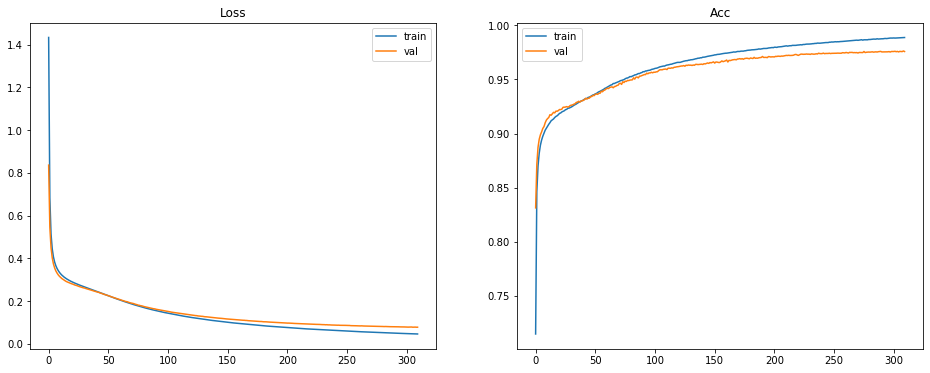

In [77]:
plot_history(history)

Epoch 1, tloss 0.20 t_acc: 0.94  vloss 0.21  v_acc: 0.94
Epoch 2, tloss 0.20 t_acc: 0.94  vloss 0.20  v_acc: 0.94
Epoch 3, tloss 0.20 t_acc: 0.94  vloss 0.20  v_acc: 0.94
Epoch 4, tloss 0.20 t_acc: 0.94  vloss 0.20  v_acc: 0.94
Epoch 5, tloss 0.20 t_acc: 0.95  vloss 0.20  v_acc: 0.94
Epoch 250, tloss 0.05 t_acc: 0.99  vloss 0.08  v_acc: 0.98
finished training_loop().


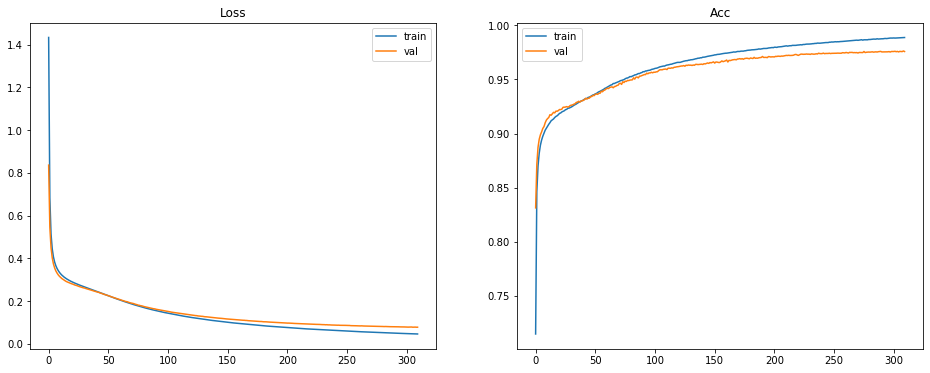

In [76]:
history = training_loop(n_epochs=250,
                        optim=optimizer,
                        model=net,
                        loss_fn=loss_fn, 
                        dl_train=data_loader_train,
                        dl_val = data_loader_test,
                        hist=history)
plot_history(history)

### Practicums
- Modify batch_size to examine the behavior of the training loop.
- Try other values of learning_rate
- Try Adam
    - what is Adam by the way?